In [1]:
#builtin
import json
import os
from datetime import datetime

#external
import pyproj
import rasterio as rio
import requests
from rasterio.enums import ColorInterp
from rasterio.mask import mask
from rasterio.warp import Resampling
from shapely.geometry import Polygon
from shapely.ops import transform

{
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          -87.8741455078125,
          80.3025547350612
        ],
        [
          -87.5006103515625,
          80.02955732601929
        ],
        [
          -86.51184082031249,
          79.72938465835632
        ],
        [
          -85.10009765625,
          79.88201996361602
        ],
        [
          -85.484619140625,
          80.30718013404172
        ],
        [
          -87.8741455078125,
          80.3025547350612
        ]
      ]
    ]
  }
}


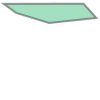

In [2]:
# load a search polygon (Eureka)
with open('../assets/query_aoi.geojson') as f:
    aoi = json.load(f)['features'][0]
print(json.dumps(aoi, indent=2))
poly = Polygon(aoi['geometry']['coordinates'][0])
poly

In [3]:
HLS_SEARCH_URL = 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search?'
print(HLS_SEARCH_URL)

https://cmr.earthdata.nasa.gov/stac/LPCLOUD/search?


In [4]:
# unclear how the STAC `intersects` parameter works - might be misconfigured NASA-side as it produces wrong results when used with raw geojson
search_params = {
    'bbox': f'{",".join([str(round(f,3)) for f in list(poly.bounds)])}',
    'limit': 5,
    'datetime': '2020-07-11T21:31:25Z/2021-03-04T20:55:00Z',
    'collections': ['HLSS30.v1.5'],
    'page': 1
    #'intersects': aoi
}

print(json.dumps(search_params, indent=2))

{
  "bbox": "-87.874,79.729,-85.1,80.307",
  "limit": 5,
  "datetime": "2020-07-11T21:31:25Z/2021-03-04T20:55:00Z",
  "collections": [
    "HLSS30.v1.5"
  ],
  "page": 1
}


In [5]:
# unclear why NASA-CMR decided to use POST instead of GET
search_response = requests.post(HLS_SEARCH_URL, json=search_params).json()
print('%d features found with first query' % len(search_response['features']))
feats = search_response['features']
# pagination is cool
try:
    next_page = [l['body']['page'] for l in search_response['links'] if l['rel'] == 'next'][0]
except IndexError:
    next_page = None
while next_page is not None:
    # increment pagenum in search_params
    search_params.update({'page': next_page})
    # get the next page
    search_response = requests.post(HLS_SEARCH_URL, json=search_params).json()
    feats.extend(search_response['features'])
    try:
        next_page = [l['body']['page'] for l in search_response['links'] if l['rel'] == 'next'][0]
    except IndexError:
        next_page = None
print('%d total features found by the query parameters' % len(feats))

1 features found with first query
1 total features found by the query parameters


In [6]:
[f['properties']['datetime'] for f in feats]

['2020-07-11T21:31:27.859Z']

In [7]:
search_response['features'][0]

{'type': 'Feature',
 'id': 'G1949921562-LPCLOUD',
 'stac_version': '1.0.0-beta.2',
 'stac_extensions': ['eo'],
 'collection': 'HLSS30.v1.5',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-92.9740114, 79.6750777],
    [-87.3864085, 79.9293289],
    [-87.3668679, 79.9311576],
    [-87.261827, 80.1167733],
    [-91.0823543, 80.1599323],
    [-93.0010488, 80.1653366],
    [-93.0009996, 79.6750788],
    [-92.9740114, 79.6750777]]]},
 'bbox': [-93.001049, 79.675078, -87.261827, 80.165337],
 'links': [{'rel': 'self',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v1.5/items/G1949921562-LPCLOUD'},
  {'rel': 'parent',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v1.5'},
  {'rel': 'collection',
   'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD/collections/HLSS30.v1.5'},
  {'rel': 'root', 'href': 'https://cmr.earthdata.nasa.gov/stac/'},
  {'rel': 'provider', 'href': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD'},
  {'rel': 'vi

In [8]:
def remote_to_local(stac_feature, clip_poly, target_dir):
    '''
    Given an Earthdata STAC feature (dictionary), construct a local geotiff using
    the RGB channels from the remote STAC feature clipped to the polygon we set earlier
    '''
    # extract some information
    tile_str, date_str = stac_feature["assets"]["Fmask"]["href"].split(".")[-6:-4]
    tif_date = datetime.strptime(date_str, '%Y%jT%H%M%S')
    # product.type.datetime.tileindex.version.tif
    tif_name = os.path.join(
        target_dir, 
        f'HLS.S30.{tif_date.strftime("%Y%m%dT%H%M%S")}.{tile_str}.v1.5.tif'
    )
    print(tif_name)
    if os.path.exists(tif_name):
        return tif_name
    # get RGB sources
    r = rio.open(stac_feature['assets']['B04']['href'])
    # save a copy of the red-band metadata for later use
    meta = r.meta.copy()
    g = rio.open(stac_feature['assets']['B03']['href'])
    b = rio.open(stac_feature['assets']['B02']['href'])
    # transform clip-geometry to match source
    src = pyproj.CRS.from_epsg(4326)
    dst = pyproj.CRS(r.crs)
    trans = pyproj.Transformer.from_crs(crs_from=src, crs_to=dst, always_xy=True)
    poly_utm = transform(trans.transform, clip_poly)
    # apply clip-geometry to source
    r_masked, mask_transform = mask(r, [poly_utm], crop=True)
    g_masked, _ = mask(g, [poly_utm], crop=True)
    b_masked, _ = mask(b, [poly_utm], crop=True)
    # update the metadata to match the new clipped boundaries and add some tiling/compression stuff
    meta.update({
        'count': 3,
        'height': r_masked.shape[1],
        'width': r_masked.shape[2],
        'transform': mask_transform,
        'tiled': True,    
        'compress': 'DEFLATE',
        'tilexsize': 256,
        'tileysize': 256,
    })
    # create the local dataset and build overviews for a series of zoomlevels
    with rio.open(tif_name, 'w', **meta) as dst:
        for band_id, band in enumerate([r_masked, g_masked, b_masked], start=1):
            dst.write_band(band_id, band[0])
        dst.colorinterp = [ColorInterp.red, ColorInterp.green, ColorInterp.blue]
        dst.build_overviews([2, 4, 8, 16], Resampling.cubic)
        dst.update_tags(ns='rio_overview', resampling=Resampling.cubic)
    return tif_name

In [9]:
%%time
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl
with rio.Env(
    CPL_VSIL_CURL_ALLOWED_EXTENSIONS='.tif',
    GDAL_DISABLE_READDIR_ON_OPEN='YES',
    GDAL_HTTP_UNSAFESSL='YES',
    GDAL_HTTP_COOKIEFILE='~/cookies.txt',
    GDAL_HTTP_COOKIEJAR='~/cookies.txt'
):
    tifs = [
        remote_to_local(feat, poly, '../test/')
        for feat in feats
    ]

../test/HLS.S30.20200711T213051.T15XWJ.v1.5.tif
CPU times: user 415 ms, sys: 25.6 ms, total: 441 ms
Wall time: 43.7 s
